# Part 6 - Google Trends data

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

In this notebook I will describe my code to download data from Google trends 
as well as code to pull *keyword suggestions" based on some *seed* keywords.

I start in the usual way I do with all my notebooks with
* imports
* print version for Python and non standar modules

This boilerplate code is evolving and hopefully getting better

In [3]:
import os
import sys
import datetime
import inspect
import pandas as pd
import plotnine as pn
import pytrends as pt
from pytrends.request import TrendReq

In [4]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    mname = name
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        mname = name
        if hasattr(mod, "__path__"):
            mname = os.path.split(mod.__path__[0])[1]
        print("version {1} of {0} as {2} ".format(mname, name, mod.__version__))
    elif hasattr(mod, "__file__") and "site-packages" in mod.__file__:
        print("No __version__ for {0} as {1}".format(mname, name))
del mod
del name

version 3.7.9 of Python
No __version__ for _sh as _sh
version pd of pandas as pd 
version pn of plotnine as pn 
No __version__ for pt as pt


## Pytrends api
I'm new to pytrends but I'll make a go of using it.

Seems like the steps are
* create a *TrendReq* object which is usually called *pytrends*.
* configure the TrendReq object, called pytrends, by calling *build_payload* with pytrends with parameters for 
  - a keyword list
  - a timeframe
  - a geography reference
* call *interest_over_time* to get the data, returns a dataframe
 
It will be useful to wrap some of the code that sets up the paramaters for  ***build_payload*** into a function

I'll call the function *set_payload*

In [5]:
def set_payload(trend_req, kw_list, nweeks=100, geo='US', cat=60, grop=''):
    end_date = datetime.date.today()
    start_date = datetime.date.today() - datetime.timedelta(weeks=nweeks)
    timeframe = start_date.strftime("%Y-%m-%d") + " " + end_date.strftime("%Y-%m-%d")  
    trend_req.build_payload(kw_list, cat=cat, timeframe=timeframe, geo=geo, gprop=grop)    
    return trend_req

In [6]:
tr = TrendReq(hl='en-US', tz=360)
tr = set_payload(trend_req=tr, kw_list=['work'], cat=60, nweeks=20, geo='US', grop='')
df = tr.interest_over_time()
print(df.head(2))
print(df.tail(2))

            work  isPartial
date                       
2020-07-06    87      False
2020-07-07    95      False
            work  isPartial
date                       
2020-11-20    74      False
2020-11-21    52      False


I don't know what *isPartial* means yet.  The module documentation does not say much about it.
I read somewere *You can ignore isPartial for now: that field lets you know if the data point is complete for that particular date*, so I plan to remove an ignore it.
Now let's try with more keywords and plot the results

<AxesSubplot:xlabel='date'>

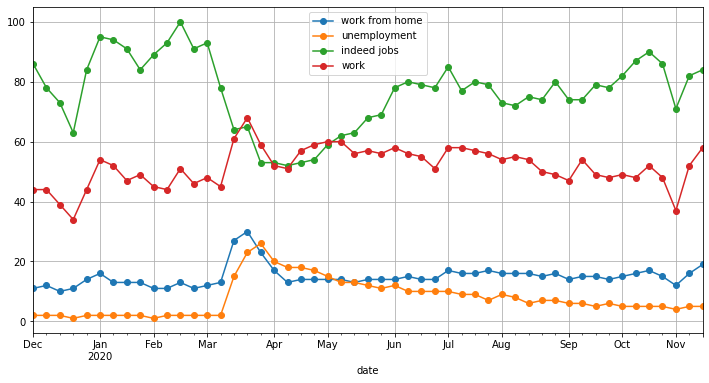

In [7]:
kw_list = [  "work from home",  "unemployment", "indeed jobs", "work"]
nweeks = 52
tr = set_payload(trend_req=tr, kw_list=kw_list, nweeks=nweeks, )
df = tr.interest_over_time().drop("isPartial", axis=1)
df.plot(figsize=[12,6], grid=True, marker='o')

Notes
* the resulting data is weekly. I have read that that is the standard when the time span is over 90 days.
* There is a *get_daily_data* method available in the pytrends module but I ok with weekly for now.


## Getting More keywords
OK, so far so good.  Maybe using more keywords would give us better preictor variables, but what other keywords might be useful.  The trend_requst object gives 2 methods that seem like they might help here
* relate_queries
* suggestions
I'm not sure the difference but for now I am usig related_queries.
It returns a *score* which I belive is some measure of how related the other query is.
Below I have some code to do the following
* start with some seed queries, push then into a queue
* pop an item off the queue, an item includes a keyword and a score
* if the score is above a threshold 
 - add the keyword to the keyword list
 - call *related queries* on the keyword and push all results above a cutoff into the queue

In [8]:
from collections import deque
import time

sleeptime = 0.0001
verbosity = 1
max_keywords = 100
min_score = 98

keywords2try = deque()
keyword_tups = deque()
keyword_set = set()

# seed the queue with a few terms
keywords2try.appendleft(("jobs", 101, 0, 'root', 101))
keywords2try.appendleft(("unemployment", 101, 0, 'root', 101))
print("Start {0}".format(datetime.datetime.now()))
while len(keywords2try) > 0:
    if len(keyword_tups) > max_keywords:
        break
    kw, score, level, parent, parent_score = keywords2try.pop()
    if kw in keyword_set:
        if verbosity > 1:
            print("{0} already in set".format(kw))
        continue
    if verbosity > 0:
        print("<kw#{1}='{0}''>, ".format(kw, len(keyword_tups)+1), end='')
    # add to keyword_tups and keyword_set
    keyword_tups.appendleft((kw, score, level, parent, parent_score))
    keyword_set.add(kw)
    
    trend_req = TrendReq(hl='en-US', tz=360)    
    trend_req = set_payload(trend_req, kw_list=[kw])
    # do I need to insert some wait time here?
    time.sleep(sleeptime)
    try:
        related = trend_req.related_queries()
    except Exception as e:
        last_exception = e
        exc_type, exc_obj, exc_tb = sys.exc_info()
        related = "error"
        break        
    if not related:
        if verbosity > 1:
            print("\t No related")
        continue
    if 'top' not in related[kw].keys():
        if verbosity > 1:
            print("\tNo top")
        continue
    df = related[kw]['top']
    if df is None:
        if verbosity > 1:
            print("\ttop is empty")
        continue
    for tup in df.itertuples():
        child_score = score * tup.value/float(100)
        if child_score > min_score and tup.query not in keyword_set:
            if verbosity > 1:
                print("\tpushing {0}".format(tup.query))
            keywords2try.appendleft((tup.query, child_score, level+1, kw, score))
if related == "error":
    import traceback
    traceback.print_tb(exc_tb)
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, fname, exc_tb.tb_lineno)  
    raise Exception(last_exception)
print("Done {0}".format(datetime.datetime.now()))
kw_df = pd.DataFrame(data=list(keyword_tups), columns=['keyword', 'score', 'level','parent', 'parent_score']).sort_values(by="score", ascending=False)
kw_df.sort_values(by='score', ascending=True)
kw_df.tail()

Start 2020-11-23 15:32:47.029725
<kw#1='jobs''>, <kw#2='unemployment''>, 

ReadTimeout: HTTPSConnectionPool(host='trends.google.com', port=443): Read timed out. (read timeout=5)

In [ ]:
print("Found {0} queries".format(kw_df.shape[0]))
kw_df.sort_values(by="score", inplace=True)
out_dir = "./data"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
try:
    kw_df.to_csv(os.path.join(out_dir, "google_keywords.csv"))
except Exception as exc:
    print(exc)
    raise(exc)

In [ ]:
trend_req = TrendReq(hl='en-US', tz=360)
nyears = 2
trends_df = pd.DataFrame()
for tup in kw_df.itertuples():
    kw_list = [tup.keyword]
    nweeks = 52*nyears
    trend_req = set_payload(trend_req, kw_list, nweeks=nweeks, )
    temp_df = trend_req.interest_over_time()
    temp_df.drop('isPartial', axis=1, inplace=True)
    if trends_df.shape[0] == 0:
        trends_df = temp_df
    else:
        trends_df = trends_df.join(temp_df)
print(trends_df.columns)

In [ ]:
trends_df.columns
trends_df.head()

In [ ]:
import matplotlib.pyplot as plt

trends_df.plot(figsize=(20, 10))
plt.legend(loc='lower left')
plt.show()

In [ ]:
import datetime
print(datetime.datetime.now())